# Use Case: Anomalie-Erkennung im Luftraum

**Ziel:** Wir wollen automatisch ungewöhnliche Flugbewegungen identifizieren, ohne manuelle Regeln zu definieren ("Unsupervised Learning").

**Methode:** Wir nutzen einen **Isolation Forest**. Dieser Algorithmus isoliert Ausreißer, indem er zufällige Schnitte in den Daten macht. Je schneller ein Punkt isoliert ist, desto "anormaler" ist er.

**Erwartete Anomalien:**
* Messfehler (z.B. GPS-Sprünge)
* Nicht-Flugzeuge (z.B. Wetterballons)
* Sicherheitsrelevante Ereignisse (z.B. Kampfjets oder Notfälle)

--- STARTING ANOMALY DETECTION (SPEED & ALTITUDE) ---
📂 Lade Daten aus: run_1769032455
🤖 Trainiere Isolation Forest (Features: ['velocity', 'baroaltitude'], Contamination: 1%)...
⚠️ Gefundene Anomalien: 5675 (Visuelle Ausreißer)
🎨 Erstelle Diagramm...


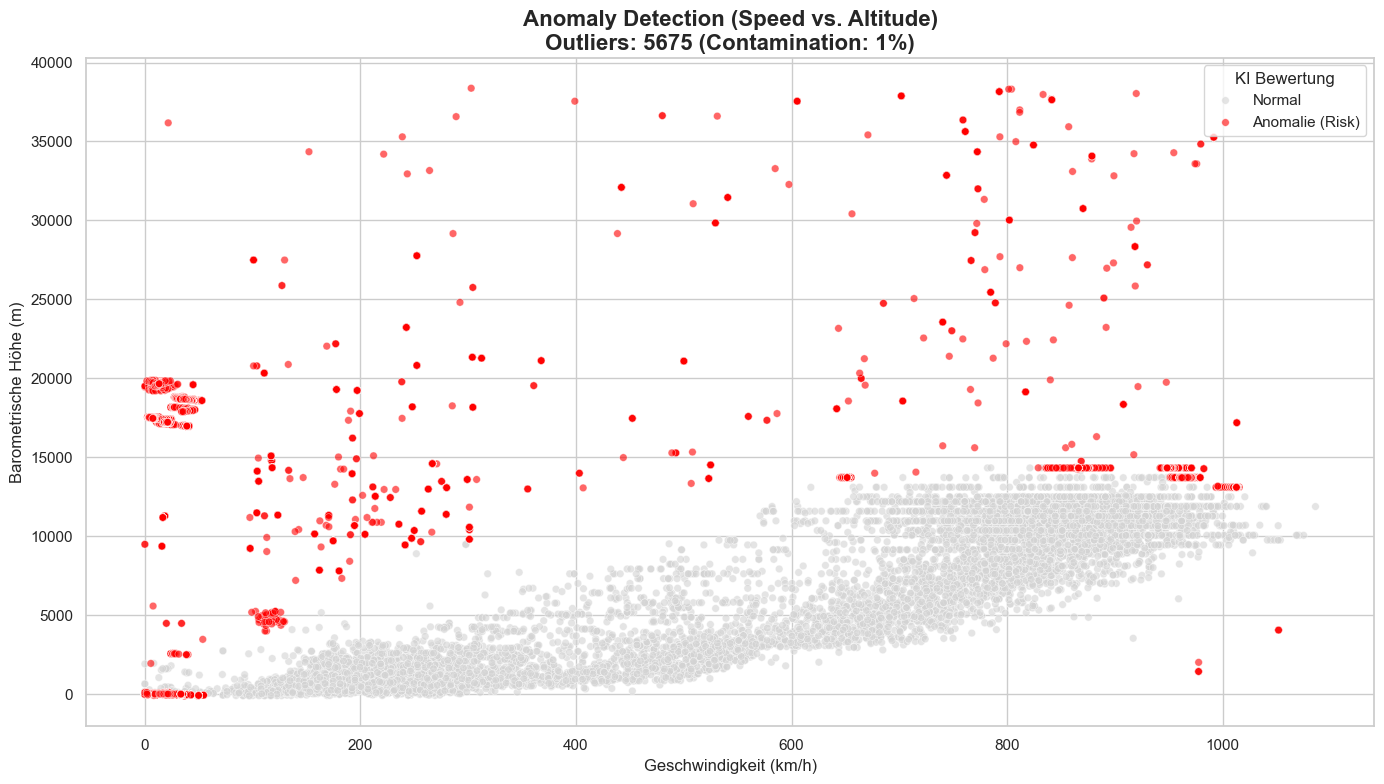

In [ ]:
import pandas as pd
import glob
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest

sns.set_theme(style="whitegrid")

print("--- STARTING ANOMALY DETECTION (SPEED & ALTITUDE) ---")

# 1. DATEN LADEN
base_path = "../data/processed/run_*"
if not glob.glob(base_path):
    base_path = "../../data/processed/run_*"
    
list_of_dirs = glob.glob(base_path)
latest_run = max(list_of_dirs, key=os.path.getctime)
print(f"📂 Lade Daten aus: {os.path.basename(latest_run)}")

df = pd.read_parquet(latest_run)

# 2. PREPARATION
# Wir reparieren die Datentypen für Speed und Höhe
cols_to_fix = ['baroaltitude', 'velocity']
for col in cols_to_fix:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Nur fliegende Flugzeuge ohne fehlende Werte
df_ml = df[df['onground'] == 'False'].dropna(subset=cols_to_fix).copy()

# ---------------------------------------------------------
# KONFIGURATION
# ---------------------------------------------------------

# 3. ANOMALIE-ERKENNUNG MIT ISOLATION FOREST

features = ['velocity', 'baroaltitude']
X = df_ml[features]

print(f"🤖 Trainiere Isolation Forest (Features: {features}, Contamination: 1%)...")

# Wir suchen nur die extremsten Ausreißer an den Rändern.
model = IsolationForest(n_estimators=100, contamination=0.01, random_state=42, n_jobs=-1)

# ---------------------------------------------------------

df_ml['anomaly_score'] = model.fit_predict(X)
df_ml['status'] = df_ml['anomaly_score'].apply(lambda x: 'Anomalie (Risk)' if x == -1 else 'Normal')
anomalies = df_ml[df_ml['status'] == 'Anomalie (Risk)']

print(f"⚠️ Gefundene Anomalien: {len(anomalies)} (Visuelle Ausreißer)")

# 4. VISUALISIERUNG
print("🎨 Erstelle Diagramm...")
plt.figure(figsize=(14, 8))

# Sample für Hintergrund
n_samples = min(10000, len(df_ml[df_ml['status'] == 'Normal']))
df_normal_sample = df_ml[df_ml['status'] == 'Normal'].sample(n=n_samples, random_state=42)
df_plot = pd.concat([df_normal_sample, anomalies])

# Umrechnung für das Diagramm
df_plot['velocity_kmh'] = df_plot['velocity'] * 3.6

sns.scatterplot(
    data=df_plot, 
    x='velocity_kmh',      # KM/H
    y='baroaltitude',      # Meter
    hue='status', 
    palette={'Normal': 'lightgrey', 'Anomalie (Risk)': 'red'},
    alpha=0.6,
    s=30
)

plt.title(f"Anomaly Detection (Speed vs. Altitude)\nOutliers: {len(anomalies)} (Contamination: 1%)", fontsize=16, fontweight='bold')
plt.xlabel("Geschwindigkeit (km/h)")
plt.ylabel("Barometrische Höhe (m)")

# Legende oben rechts, damit sie nicht stört
plt.legend(title="KI Bewertung", loc='upper right')

plt.tight_layout()
plt.show()

# Grundlagen & Analyse der Anomalien

### 1. Physikalische Grundlagen
Um die Ergebnisse zu verstehen, muss man wissen, wie Verkehrsflugzeuge fliegen:
* **Höhe & Geschwindigkeit:** Mit steigender Höhe nimmt die Luftdichte ab. Das verringert den Luftwiderstand, weshalb Flugzeuge in großer Höhe deutlich schneller fliegen können und müssen (um Auftrieb zu erhalten). Im Diagramm sehen wir daher eine graue "Wolke", die sich von links unten nach rechts oben zieht.
* **Normwerte für Verkehrsjets (Baseline):**
    * **Start/Landung:** ca. 250–300 km/h (Höhe < 1.000m)
    * **Reiseflug:** ca. 850–950 km/h (Höhe ca. 10.000–12.000m)
    * **Steig-/Sinkrate:** Normal sind ca. 10 m/s.

---

### 2. Interpretation der Ergebnisse (KI-Analyse)

Die KI (Isolation Forest) wurde konfiguriert, um die **Top 1%** der extremsten Datenpunkte zu finden. Die Analyse der roten Anomalien im Scatterplot zeigt drei klare Cluster:

1.  **Der "Physik-Check" (Die graue Masse):**
    * Die normalen Flüge folgen exakt der erwarteten Aerodynamik. Die KI hat diesen Bereich korrekt als "Normal" gelernt und ignoriert ihn.

2.  **Anomalie A: "Das stehende Objekt" (Oben Links):**
    * Wir sehen rote Punkte in extremer Höhe (**> 18.000m**) bei fast **0 km/h**.
    * *Fazit:* Ein Flugzeug würde hier sofort abstürzen (Strömungsabriss). Es handelt sich mit sehr hoher Wahrscheinlichkeit um **Wetterballons** oder GPS-Fehler (Null-Island-Effekt), die korrekt als "Nicht-Flugzeug" erkannt wurden.

3.  **Anomalie B: "Der aggressive Tiefflieger" (Unten Rechts):**
    * Objekte mit hoher Geschwindigkeit (**> 800 km/h**) in sehr niedriger Höhe (**< 2.000m**).
    * *Fazit:* Dies ist für zivile Passagierjets unüblich (Lärmschutz, Luftwiderstand, Vogelschlag-Gefahr). Solche Muster deuten oft auf **militärische Übungsflüge**, fehlerhafte Höhenmesser oder extremen Rückenwind (Jetstream) hin.

# Deep Dive: Geografische Analyse & Kontext

**Das Problem:**
Im vorherigen Schritt haben wir rein mathematische Anomalien gefunden (z.B. "zu schnell für die Höhe"). Aber eine Zahl allein erzählt noch keine Geschichte. Ein Wert von `0 km/h` kann ein Fehler sein – muss aber nicht.

**Die Lösung:**
Wir verknüpfen die Anomalien mit ihren **GPS-Koordinaten (`lat`, `lon`)**.
Wir nutzen die Bibliothek **Cartopy**, um die Flugbewegungen auf eine echte Weltkarte zu projizieren.

**Ziele dieses Schritts:**
1.  **Realitäts-Check:** Liegen die Punkte auf Landmassen (realistisch) oder mitten im Ozean (oft Sensor-Fehler/Null-Island)?
2.  **Hotspot-Analyse:** Gibt es bestimmte Regionen (z.B. USA, Europa), in denen sich die "Verrückten" häufen?
3.  **Abdeckung:** Wo haben wir überhaupt Daten? (Visualisiert durch graue Hintergrundpunkte).

--- DEEP DIVE: KONTEXT & LOCATION ---
✈️ Plotten von 5582 Flügen + Anomalien...


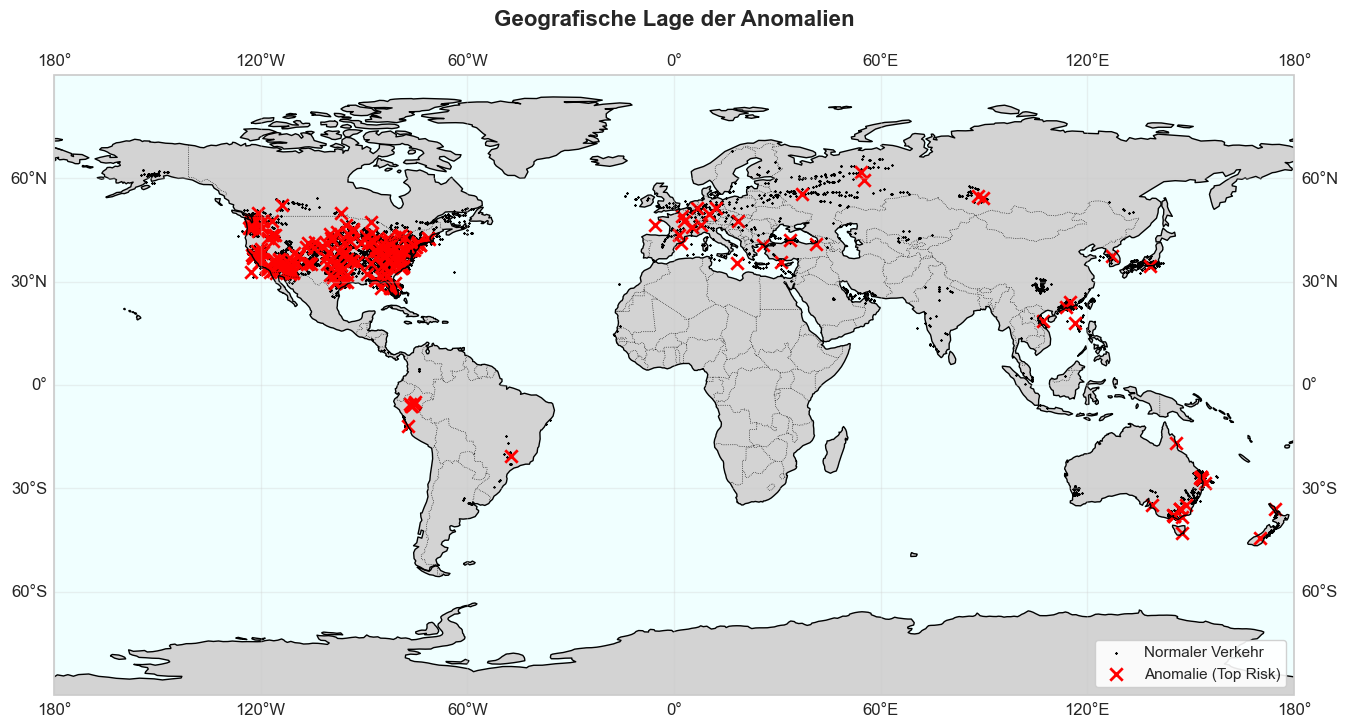

In [7]:
import matplotlib.pyplot as plt
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import warnings

# SCHALLDÄMPFER: Wir unterdrücken Warnungen für den Output
warnings.filterwarnings('ignore')

print("--- DEEP DIVE: KONTEXT & LOCATION ---")

# 1. KOORDINATEN & DATEN
cols_geo = ['lat', 'lon']
for col in cols_geo:
    df_ml[col] = pd.to_numeric(df_ml[col], errors='coerce')

# WICHTIG: Wir erstellen eine explizite Kopie, damit Pandas nicht meckert
anomalies = anomalies.copy() 
for col in cols_geo:
    anomalies[col] = pd.to_numeric(anomalies[col], errors='coerce')

# 2. BEREINIGUNG (Deduplizierung)
unique_anomalies = anomalies.sort_values('velocity', ascending=False).drop_duplicates(subset=['icao24'])

# 3. WO SIND DIE? (Die Karte)
plt.figure(figsize=(16, 10))

# Geo-Projektion
ax = plt.axes(projection=ccrs.PlateCarree())

# Features
ax.add_feature(cfeature.LAND, facecolor='lightgray') 
ax.add_feature(cfeature.OCEAN, facecolor='azure')     
ax.add_feature(cfeature.COASTLINE, linewidth=1)       
ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5) 

# Sample für Hintergrund
df_normal_sample = df_ml[df_ml['status'] == 'Normal'].dropna(subset=['lat', 'lon']).sample(frac=0.01, random_state=42)

print(f"✈️ Plotten von {len(df_normal_sample)} Flügen + Anomalien...")

# Normaler Verkehr
ax.scatter(df_normal_sample['lon'], df_normal_sample['lat'],
           c='black', s=1, marker='x', transform=ccrs.PlateCarree(), label='Normaler Verkehr')

# Anomalien
ax.scatter(unique_anomalies['lon'], unique_anomalies['lat'],
           c='red', s=80, marker='x', linewidth=2, transform=ccrs.PlateCarree(), label='Anomalie (Top Risk)')

# Design
ax.set_global()
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha=0.3)
plt.title("Geografische Lage der Anomalien", fontsize=16, fontweight='bold', pad=20)
plt.legend(loc='lower right', frameon=True, facecolor='white', framealpha=0.9)

plt.show()

### Interpretation der Weltkarte

Die Visualisierung liefert spannende Erkenntnisse über die Natur unserer Daten und der gefundenen Anomalien:

1.  **Daten-Bias & Abdeckung (Graue Punkte):**
    * Die grauen Punkte zeigen den normalen Flugverkehr. Man erkennt sofort: Unsere Datenbasis (OpenSky Network) hat die beste Abdeckung in **Nordamerika, Europa und Australien**. In Afrika und über den Ozeanen gibt es kaum Empfänger.
    * *Wichtig:* Dass wir dort keine Anomalien finden, heißt nicht, dass es keine gibt – wir haben dort nur keine Sensoren ("Selection Bias").

2.  **Cluster USA & Europa (Rote Kreuze):**
    * Wir sehen eine massive Häufung von Anomalien in den **USA** und **Mitteleuropa**.
    * *Grund:* Dies sind die Lufträume mit der höchsten Verkehrsdichte weltweit. Wo mehr geflogen wird, passieren statistisch auch mehr ungewöhnliche Manöver (oder Messfehler). Zudem gibt es in den USA sehr viel "General Aviation" (Privatpiloten, kleine Cessnas), die oft unruhiger fliegen als große Linienjets.

3.  **Plausibilitäts-Prüfung:**
    * Die Anomalien liegen fast ausschließlich über **Landmassen**.
    * Das ist ein gutes Zeichen! Es deutet darauf hin, dass es sich um **echte Flugzeuge** handelt und nicht um GPS-Artefakte im Ozean (wie der berühmte "Null-Island" Fehler bei Koordinate 0,0).

--- 🚀 START: CONTEXT-AWARE ANOMALY DETECTION ---
📂 1. Lade Flugdaten: run_1769032455
📚 2. Lade Aircraft Database: aircraft_database.parquet
🔗 3. Verknüpfe Daten (Left Join)...
   -> Datensatzgröße: 567,496 Zeilen
   -> Davon mit Flugzeug-Infos: 527,334 (92.9%)
🤖 4. Trainiere KI (Isolation Forest)...
🧠 5. Analysiere Kontext (Hubschrauber-Check)...

--- ERGEBNISSE ---
status_context
Normal                    561821
Risk (Unexplained)          5511
Erklärbar (Helicopter)       163
Risk (Militär/Special)         1
Name: count, dtype: int64

🎨 Erstelle Plot...


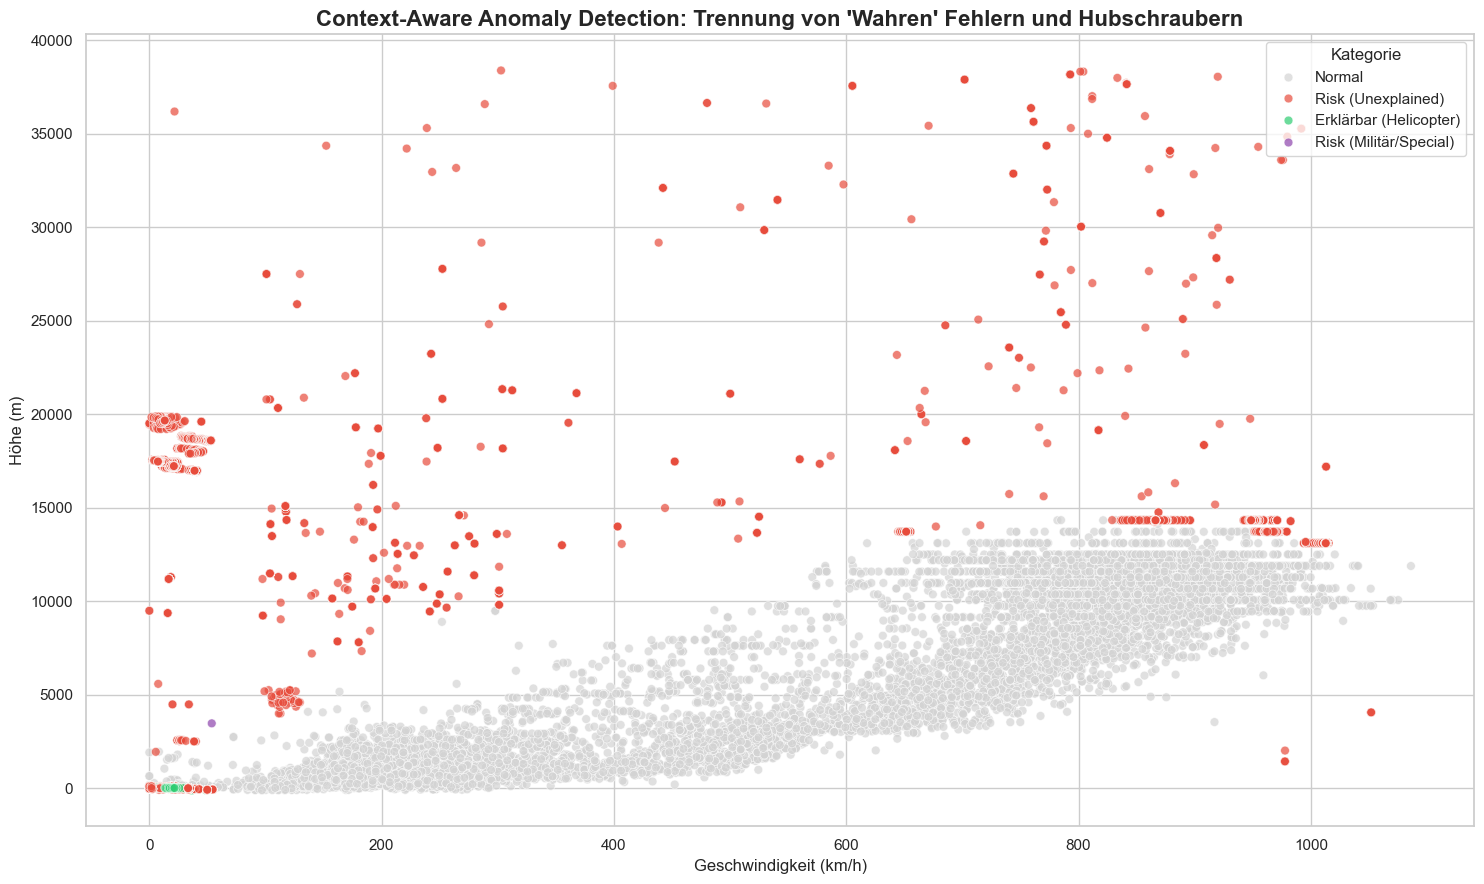


--- 🕵️‍♂️ DEEP DIVE: UNEXPLAINED RISKS (Top 5) ---
        callsign    velocity  baroaltitude manufacturerName             model  \
13184   JAL304    292.190606       4053.84           Boeing  787-8 Dreamliner   
14646   JAL304    292.190606       4053.84           Boeing  787-8 Dreamliner   
15173   JAL304    292.190606       4053.84           Boeing  787-8 Dreamliner   
441205  ETH575    282.017150      13106.40           Boeing            B787-8   
442872  ETH575    282.017150      13106.40           Boeing            B787-8   

         categoryDescription      status_context  
13184                   None  Risk (Unexplained)  
14646                   None  Risk (Unexplained)  
15173                   None  Risk (Unexplained)  
441205  Heavy (> 300000 lbs)  Risk (Unexplained)  
442872  Heavy (> 300000 lbs)  Risk (Unexplained)  

--- 🚁 DEEP DIVE: HELICOPTERS (Entlastet) ---
        callsign   velocity  baroaltitude    manufacturerName model  \
108233  HUMMEL3   13.532909       -106

In [1]:
import pandas as pd
import glob
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest

# Style
sns.set_theme(style="whitegrid")

print("--- 🚀 START: CONTEXT-AWARE ANOMALY DETECTION ---")

# ==========================================
# 1. DATEN LADEN & JOINEN
# ==========================================

# A) Flugdaten (Letzter Run)
base_path = "../data/processed/run_*"
if not glob.glob(base_path): base_path = "../../data/processed/run_*" # Fallback
latest_run = max(glob.glob(base_path), key=os.path.getctime)
print(f"📂 1. Lade Flugdaten: {os.path.basename(latest_run)}")
df_flights = pd.read_parquet(latest_run)

# Typen reparieren
for col in ['velocity', 'baroaltitude']:
    df_flights[col] = pd.to_numeric(df_flights[col], errors='coerce')
df_ml = df_flights[df_flights['onground'] == 'False'].dropna(subset=['velocity', 'baroaltitude']).copy()

# B) Aircraft Database (Stammdaten)
# Pfad anpassen falls nötig!
db_path = "../data/external/aircraft_database.parquet"
if not os.path.exists(db_path): db_path = "../../data/external/aircraft_database.parquet"

print(f"📚 2. Lade Aircraft Database: {os.path.basename(db_path)}")
df_aircraft = pd.read_parquet(db_path)

# C) Der JOIN (Left Join auf icao24)
print("🔗 3. Verknüpfe Daten (Left Join)...")
df_enriched = pd.merge(df_ml, df_aircraft, on='icao24', how='left')

print(f"   -> Datensatzgröße: {len(df_enriched):,} Zeilen")
print(f"   -> Davon mit Flugzeug-Infos: {df_enriched['model'].notna().sum():,} ({df_enriched['model'].notna().mean():.1%})")

# ==========================================
# 2. BASELINE ANOMALY DETECTION (Der "dumme" Algo)
# ==========================================
print("🤖 4. Trainiere KI (Isolation Forest)...")
features = ['velocity', 'baroaltitude']
model = IsolationForest(n_estimators=100, contamination=0.01, random_state=42, n_jobs=-1)
df_enriched['anomaly_score'] = model.fit_predict(df_enriched[features])

# ==========================================
# 3. CONTEXT FILTERING (Der "intelligente" Teil)
# ==========================================
print("🧠 5. Analysiere Kontext (Hubschrauber-Check)...")

def classify_status(row):
    # 1. Wenn KI sagt "Normal" -> Bleibt Normal
    if row['anomaly_score'] == 1:
        return 'Normal'
    
    # 2. KI sagt "Anomalie". Wir prüfen den Kontext:
    
    # Kontext laden (Sicherstellen, dass es Strings sind)
    cat = str(row['categoryDescription']).lower()
    model = str(row['model']).lower()
    op = str(row['operator']).lower()
    
    # CHECK A: Ist es ein Hubschrauber / Drohne?
    if 'rotorcraft' in cat or 'helicopter' in model:
        return 'Erklärbar (Helicopter)'
    
    # CHECK B: Ist es ein Segelflieger / Ultraleicht?
    if 'glider' in cat or 'ultralight' in cat:
        return 'Erklärbar (Slow Mover)'
    
    # CHECK C: Militär? (Optional, oft spannend)
    if 'force' in op or 'navy' in op or 'army' in op:
        return 'Risk (Militär/Special)'
        
    # Wenn wir keine Entschuldigung finden -> Echtes Risiko / Datenfehler
    return 'Risk (Unexplained)'

# Anwenden der Logik
df_enriched['status_context'] = df_enriched.apply(classify_status, axis=1)

# Statistik
counts = df_enriched['status_context'].value_counts()
print("\n--- ERGEBNISSE ---")
print(counts)

# ==========================================
# 4. VISUALISIERUNG (Der "Wow"-Plot)
# ==========================================
print("\n🎨 Erstelle Plot...")
plt.figure(figsize=(15, 9))

# Daten für Plot vorbereiten (km/h)
df_plot = df_enriched.copy()
df_plot['velocity_kmh'] = df_plot['velocity'] * 3.6

# Sample für Normalos (damit Plot schnell bleibt)
df_normal = df_plot[df_plot['status_context'] == 'Normal'].sample(n=min(10000, len(df_plot)), random_state=42)
df_anomalies = df_plot[df_plot['status_context'] != 'Normal']
df_viz = pd.concat([df_normal, df_anomalies])

# Custom Farben: Grau (Normal), Grün (Erklärbar), Rot (Gefahr)
palette = {
    'Normal': 'lightgrey',
    'Erklärbar (Helicopter)': '#2ecc71',   # Grün
    'Erklärbar (Slow Mover)': '#27ae60',   # Dunkelgrün
    'Risk (Unexplained)': '#e74c3c',       # Rot
    'Risk (Militär/Special)': '#8e44ad'    # Lila
}

sns.scatterplot(
    data=df_viz, x='velocity_kmh', y='baroaltitude', 
    hue='status_context', palette=palette, alpha=0.7, s=40
)

plt.title("Context-Aware Anomaly Detection: Trennung von 'Wahren' Fehlern und Hubschraubern", fontsize=16, fontweight='bold')
plt.xlabel("Geschwindigkeit (km/h)")
plt.ylabel("Höhe (m)")
plt.legend(title="Kategorie", loc='upper right', frameon=True)
plt.tight_layout()
plt.show()

# Deep Dive Tabelle
cols_show = ['callsign', 'velocity', 'baroaltitude', 'manufacturerName', 'model', 'categoryDescription', 'status_context']
print("\n--- 🕵️‍♂️ DEEP DIVE: UNEXPLAINED RISKS (Top 5) ---")
print(df_enriched[df_enriched['status_context'] == 'Risk (Unexplained)'].sort_values('velocity', ascending=False)[cols_show].head(5))

print("\n--- 🚁 DEEP DIVE: HELICOPTERS (Entlastet) ---")
print(df_enriched[df_enriched['status_context'] == 'Erklärbar (Helicopter)'][cols_show].head(5))